In [1]:
%load_ext autoreload
%autoreload 2

# Configuration

In [3]:
dataset = "webui"
task = "text"
input_format = "seq"
output_format = "html"
add_unk_token = False
add_index_token = False
add_sep_token = True
candidate_size = -1  # -1 represents the complete training set
num_prompt = 10

# Process raw data

In [4]:
import os

from src.preprocess import create_processor
from src.utils import RAW_DATA_PATH, read_pt, write_pt, read_json
from tqdm import tqdm


processor = create_processor(dataset=dataset, task=task)
base_dir = os.path.dirname(os.getcwd())


def get_processed_data(split):
    filename = os.path.join(
        base_dir, "dataset", dataset, "processed", task, f"{split}.pt"
    )
    if os.path.exists(filename):
        processed_data = read_pt(filename)
    else:
        processed_data = []
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        raw_path = os.path.join(base_dir, "dataset", dataset, "raw", f"{split}.json")
        raw_data = read_json(raw_path)
        for rd in tqdm(raw_data, desc=f"{split} data processing..."):
            processed_data.append(processor(rd))
        write_pt(filename, processed_data)
    return processed_data


processed_train_data = get_processed_data("train")
processed_val_data = get_processed_data("val")
processed_test_data = get_processed_data("test")

/scratch/muyanchen/anaconda3/envs/llm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import re

def find_elements(input_string):
    # matches = re.findall(r'el:([^\[]+)', input_string)
    # matches = [match.strip() for match in matches]
    # return matches
    matches = re.findall(r'el:([a-zA-Z_]+)', input_string)
    return matches

In [25]:
processed_test_data

[{'text': 'A page for introducing transferring money at excellent exchange rates to users. The page should include one title and a background image. At the bottom, a button is needed for users to click for further information about International transfers.',
  'ir': "[region:SingleInfo [el:title] [el:background_image]  [el:button [attr:value 'international transfers'] [attr:position 'bottom'] ] ]",
  'embedding': tensor([[-2.6642e-02,  1.8936e-02, -4.6875e-02,  1.2215e-02,  7.3586e-03,
            4.9652e-02,  8.2016e-03,  2.3305e-04,  6.3477e-02, -4.2358e-02,
            4.1260e-02,  9.2926e-03,  3.0930e-02,  3.0556e-03, -2.8229e-02,
           -1.9503e-03,  3.3295e-02,  3.3386e-02, -1.5240e-03,  1.3107e-02,
            1.0132e-02,  2.9545e-03,  4.7989e-03, -5.3978e-03, -1.6953e-02,
            1.7681e-03, -7.3318e-03, -2.7588e-02, -2.1027e-02,  8.1003e-05,
            2.8931e-02,  3.5797e-02, -1.4824e-02, -3.4912e-02, -3.7201e-02,
            9.3155e-03,  8.5526e-03, -6.8512e-03, -3.

: 

In [24]:
ir = [data['ir'] for data in processed_train_data]
# ir

In [23]:
result = []
for i in ir:
    result+=find_elements(i)
print(result)
print()
print(set(result))

['title', 'icon', 'description', 'title', 'logo', 'description', 'background_image', 'image', 'text', 'title', 'pagination', 'description', 'link', 'button', 'title', 'text', 'input', 'button', 'title', 'description', 'link', 'image', 'image', 'title', 'title', 'description', 'button', 'background_image', 'title', 'text', 'button', 'title', 'description', 'button', 'title', 'description', 'input', 'button', 'title', 'title', 'description', 'input', 'button', 'image', 'title', 'description', 'button', 'title', 'description', 'image', 'title', 'description', 'link', 'image', 'title', 'description', 'input', 'button', 'background_image', 'background_image', 'button', 'button', 'background_image', 'description', 'button', 'button', 'background_image', 'image', 'title', 'title', 'description', 'button', 'image', 'title', 'description', 'button', 'image', 'text', 'button', 'description', 'link', 'button', 'image', 'title', 'description', 'button', 'image', 'title', 'description', 'button', '

In [11]:
ir

["[region:SingleInfo [el:title [attr:value 'testimonials'] ] [el:icon [attr:value 'facebook'] ] [el:description] [el:title] ]",
 '[region:SingleInfo [el:logo] [el:description] ]',
 "[region:SingleInfo [el:background_image] [el:image [attr:size 'small'][attr:position'top'] ] [el:text][el:title] [el:pagination [attr:position 'bottom'] [attr:repeat '4'] ] ]",
 "[region:SingleInfo [el:description [attr:size 'small'] ] [el:link [attr:value 'learn more'] ] [el:button [attr:value 'close'] ] ]",
 "[region:SingleInfo [el:title] [el:text] [el:input [attr:value 'enter your email address']] [el:button [attr:value 'submit'] ] ]",
 "[region:SingleInfo [el:title [attr:value 'a cloud for your entire journey'] ] [el:description [attr:size 'small'] ] [el:link [attr:value 'view the docs'] ] [el:image] ]",
 "[region:SingleInfo [el:image] [el:title [attr:value 'new'] ] [el:title] [el:description] [el:button [attr:value 'get the  Add-in'] ] ]",
 "[region:SingleInfo [el:background_image] [el:title [attr:valu

In [6]:
len(processed_test_data)

487

# Dynamic exemplar selection

In [3]:
from src.selection import create_selector


selector = create_selector(
    task=task,
    train_data=processed_train_data,
    candidate_size=candidate_size,
    num_prompt=num_prompt,
)

test_idx = 0
exemplars = selector(processed_test_data[test_idx])

# Input-output serialization

In [4]:
from src.serialization import create_serializer, build_prompt


serializer = create_serializer(
    dataset=dataset,
    task=task,
    input_format=input_format,
    output_format=output_format,
    add_index_token=add_index_token,
    add_sep_token=add_sep_token,
    add_unk_token=add_unk_token,
)
prompt = build_prompt(serializer, exemplars, processed_test_data[test_idx], dataset)

In [15]:
print(prompt)

Please generate a layout based on the given information. You need to ensure that the generated layout looks realistic, with elements well aligned and avoiding unnecessary overlap.
Task Description: text-to-layout
There are ten optional element types, including: image, icon, logo, background, title, description, text, link, input, button. Please do not exceed the boundaries of the canvas. Besides, do not generate elements at the edge of the canvas, that is, reduce top: 0px and left: 0px predictions as much as possible.
Layout Domain: web layout
Canvas Size: canvas width is 120px, canvas height is 120px

Text: A page for navigation of the web. The page contains an icon for users to click to go to the homepage, seven links for users to click to get further information, and one input for searching.
<html>
<body>
<div class="canvas" style="left: 0px; top: 0px; width: 120px; height: 120px"></div>
<div class="background" style="left: 0px; top: 0px; width: 120px; height: 16px"></div>
<div clas

# Call GPT

In [8]:
model = "text-davinci-003"
temperature = 0.7
max_tokens = 1200
top_p = 1
frequency_penalty = 0
presence_penalty = 0
num_return = 10
stop_token = "\n\n"
os.environ["OPENAI_API_KEY"] = ""  # your api key

In [36]:
# from openai import OpenAI


# client = OpenAI()

# response = client.completions.create(
#     model=model,
#     prompt=prompt,
#     temperature=temperature,
#     max_tokens=max_tokens,
#     top_p=top_p,
#     frequency_penalty=frequency_penalty,
#     presence_penalty=presence_penalty,
#     n=num_return,
#     stop=[stop_token],
# )

In [5]:
response = list()
response.append("""Text: A page for introducing transferring money at excellent exchange rates to users. The page should include one title and a background image. At the bottom, a button is needed for users to click for further information about International transfers.
<html>
<body>
<div class="canvas" style="left: 0px; top: 0px; width: 120px; height: 120px"></div>
<div class="background" style="left: 0px; top: 0px; width: 120px; height: 120px"></div>
<div class="title" style="left: 10px; top: 10px; width: 40px; height: 20px"></div>
<div class="button" style="left: 100px; top: 100px; width: 20px; height: 10px"></div>
</body>
</html>""")
response.append("""
Text: A page for introducing transferring money at excellent exchange rates to users. The page should include one title and a background image. At the bottom, a button is needed for users to click for further information about International transfers.
<html>
<body>
<div class="canvas" style="left: 0px; top: 0px; width: 120px; height: 120px"></div>
<div class="background" style="left: 0px; top: 0px; width: 120px; height: 120px"></div>
<div class="title" style="left: 50px; top: 10px; width: 40px; height: 20px"></div>
<div class="button" style="left: 50px; top: 100px; width: 20px; height: 10px"></div>
</body>
</html>""")

# Parsing

In [37]:
# from src.parsing import Parser


# parser = Parser(dataset=dataset, output_format=output_format)
# parsed_response = parser(response)
# print(f"filter {num_return - len(parsed_response)} invalid response")

filter 0 invalid response


In [6]:
from src.parsing import Parser_HF
parser = Parser_HF(dataset=dataset, output_format=output_format)
parsed_response = parser(response)

In [7]:
parsed_response

[(tensor([6, 3, 2]),
  tensor([[0.0000, 0.0000, 1.0000, 1.0000],
          [0.0833, 0.0833, 0.3333, 0.1667],
          [0.8333, 0.8333, 0.1667, 0.0833]])),
 (tensor([6, 3, 2]),
  tensor([[0.0000, 0.0000, 1.0000, 1.0000],
          [0.4167, 0.0833, 0.3333, 0.1667],
          [0.4167, 0.8333, 0.1667, 0.0833]]))]

: 

# Layout ranking

In [12]:
from src.ranker import Ranker


ranker = Ranker()
ranked_response = ranker(parsed_response)

# Visualization

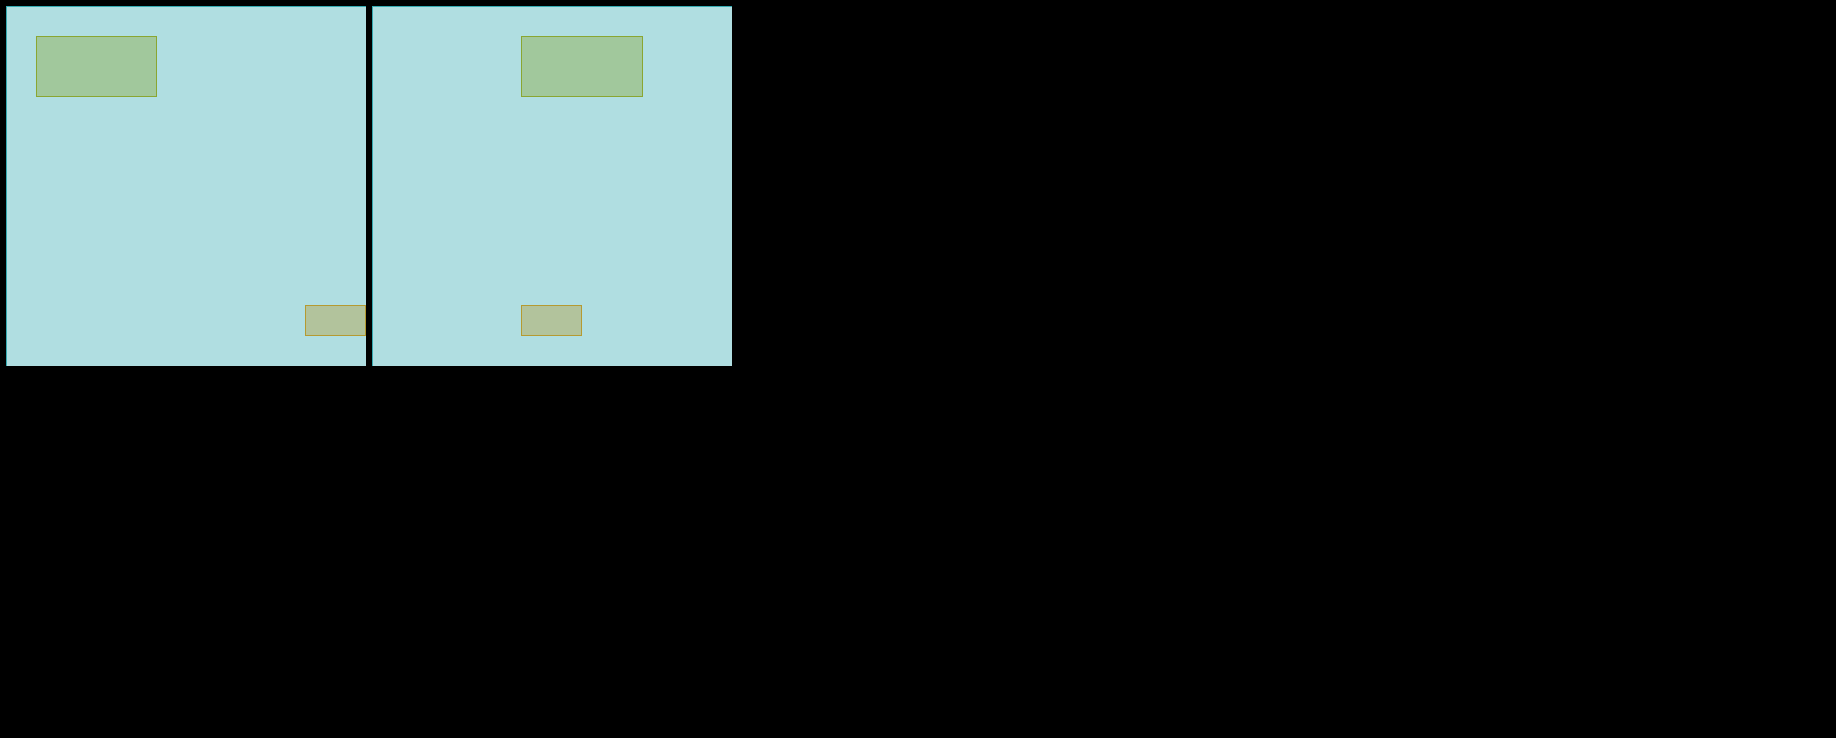

In [14]:
from src.visualization import Visualizer, create_image_grid


visualizer = Visualizer(dataset)
images = visualizer(ranked_response)
create_image_grid(images)

TODO:
1. reg expression and beam search experiment    (base line)     
2. IR Intermediate representation code ->       (up capacity)   OK
    (i) Expressiveness
    (ii) Formalism
3. evaluation code                                              OK
4. (further) llm training